In [1]:
import argparse
import sys
from torchvision.datasets import MNIST
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN,Sigmoid
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp

In [2]:
cp.random.seed(42)

train_dataset = MNIST(
        root="dataset",
        train=True,
        transform=basic_mnist_augment(train=True),
        download=False
    )
test_dataset = MNIST(
    root="dataset",
    train=False,
    transform=basic_mnist_augment(train=False),
    download=False
)

In [3]:
import numpy as np
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)
# 
# train_images = train_images.astype(np.float32) / 255.0
# test_images = test_images.astype(np.float32) / 255.0

train_set = (train_images[:50000], train_labels[:50000])

dev_set   = (train_images[50000:], train_labels[50000:])
test_set  = (test_images, test_labels)

In [4]:
layers = [
    Conv(in_channel=1, out_channel=6, kernel=3, stride=1, padding=1, weight_decay=0.00),
    # BN(normalized_dims=(0, 2, 3), param_shape=(1, 32, 1, 1), weight_decay=0.001),
    Sigmoid(),
    Pooling(kernel=2),

    Conv(in_channel=6, out_channel=16, kernel=3, stride=1, padding=1, weight_decay=0.00),
    # BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1), weight_decay=0.001),
    Sigmoid(),
    Pooling(kernel=2),

    Flatten(),
    

    Linear(in_channel=16*7*7, out_channel=120, weight_decay=0.00),
    Linear(in_channel=120, out_channel=84, weight_decay=0.00),
    Linear(in_channel=84, out_channel=10, weight_decay=0.00),
]

In [5]:
model2     = Model(layers)
optimizer = Adam(model=model2, lr=0.001)
loss_fn   = CrossEntropy(model=model2)
runner2    = RunnerM(model=model2, loss=loss_fn, optimizer=optimizer)

[Adversarial Train] Epoch 1/15: 100%|██████████| 782/782 [03:05<00:00,  4.21batch/s, accuracy=0.875, loss=0.589]
train_loss: 0.27653, train_acc: 0.92048
dev_loss  : 0.25122, dev_acc  : 0.92861
### Best model saved to: best_models_PGD\2025-05-30_14-28-27\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.92861
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/15: 100%|██████████| 782/782 [03:05<00:00,  4.21batch/s, accuracy=1, loss=0.149]    
train_loss: 0.16965, train_acc: 0.94692
dev_loss  : 0.15384, dev_acc  : 0.95566
### Best model saved to: best_models_PGD\2025-05-30_14-28-27\best_model.pickle
### Best validation accuracy updated: 0.92861 -> 0.95566
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/15: 100%|██████████| 782/782 [03:05<00:00,  4.21batch/s, accuracy=0.875, loss=0.391]
train_loss: 0.13134, train_acc: 0.96017
dev_loss  : 0.12003, dev_acc  : 0.96572
### Best model saved to: best_models_PGD\2025-05-30_14-28-27\best_model.pickle
### Best val

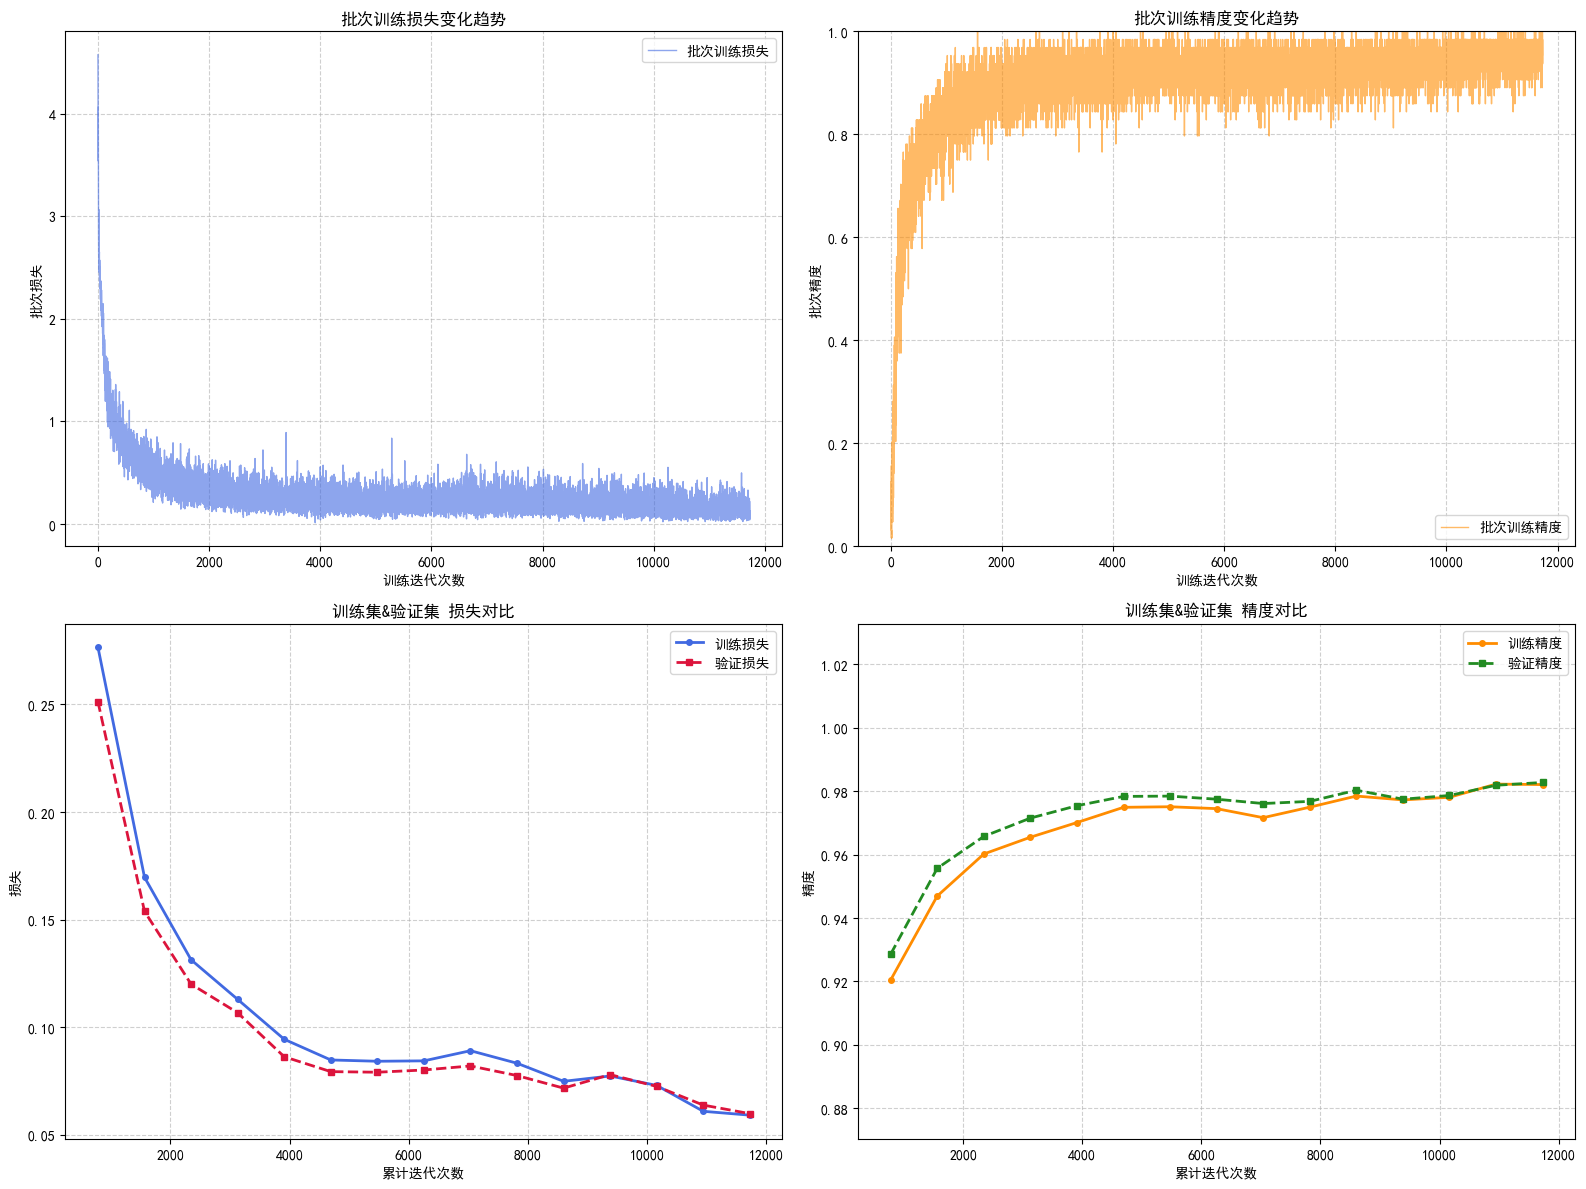

In [6]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=64,
        num_epochs=15,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        epsilon=20/255,
        shuffle=True,
        attack_strategy='PGD',
        save_dir='best_models_PGD',
        num_steps=10,
        step_size=4/255,
    )

In [5]:
advmodel= Model().load_model('best_models_PGD/minst_pdg_lenet/best_model.pickle')
advloss_fn=CrossEntropy(model=advmodel)
advrunner = RunnerM(model=advmodel, loss=advloss_fn, optimizer=None)

Model loaded from: best_models_PGD\minst_pdg_lenet\best_model.pickle


In [6]:
# 4. 测试集评估
test_loss, test_acc = advrunner.evaluate(test_set, batch_size=64,loss_fn=advloss_fn)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.05818, Test accuracy: 0.98179


In [10]:
from mynn.attack import *
adv_test_images = pgd_attack(
    model=advmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=advloss_fn,
    epsilon=20 / 255,
    num_steps=10,
    step_size=4 / 255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = advrunner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.22702, Test accuracy: 0.92553
